# 電流のシミュレーションデータ

スイッチング周波数 100kHz、タイムステップ 1e-08

`data/iL1_Sf_100k_TS1E-08.csv`


In [9]:
# 各種のインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# データをPandasで読み込み
df = pd.read_csv("../data/iL1_Sf_100k_TS1E-08.csv")
df = df.iloc[:5000]

# データを3行だけ表示
df.head(3)


,Time,I(L1)
0,0.049,2.652545
1,0.049,2.661175
2,0.049,2.669804


In [10]:
# 日本語フォント設定
plt.rcParams["font.family"] = "Hiragino Sans"
plt.rcParams["axes.unicode_minus"] = False


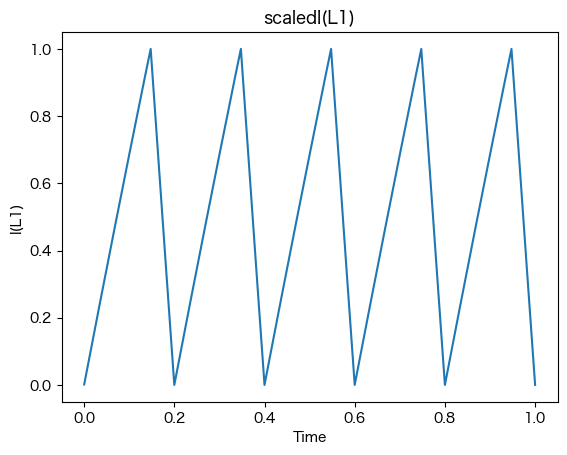

In [11]:
# ニューラルネットの入力データは0～1へ正規化する必要があるので乗客数を正規化する
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

df_scaled_x = df_scaled[:, 0]
df_scaled_y = df_scaled[:, 1]


plt.plot(df_scaled_x, df_scaled_y)
plt.xlabel("Time")
plt.ylabel("I(L1)")
plt.title("scaledI(L1)")
plt.show()

In [12]:
train_size = int(len(df_scaled) * 0.70)
test_size = len(df_scaled) - train_size
train = df_scaled[0:train_size, :]
test = df_scaled[train_size : len(df_scaled), :]
print(f"train size: {len(train)}, test size: {len(test)} ")


train size: 3500, test size: 1500 


In [13]:
# t=0,1,2,・・・9  の10個のデータから t=9+horizon のデータを予測する準備
time_stemp = 10
horizon = 1  # 何ステップ先を予測するか
n_sample = train_size - time_stemp - horizon


input_data = np.zeros((n_sample, time_stemp, 1))
correct_input_data = np.zeros((n_sample, 1))

print(input_data.shape)
print(correct_input_data.shape)


(3489, 10, 1)
(3489, 1)


In [14]:
# 空のシーケンシャルデータを入れる箱に実際のデータを入れていく
for i in range(n_sample):
    input_data[i] = df_scaled_y[i : i + time_stemp].reshape(-1, 1)
    correct_input_data[i] = df_scaled_y[
        i + time_stemp + horizon - 1 : i + time_stemp + horizon
    ].reshape(-1, 1)

input_data = torch.tensor(input_data, dtype=torch.float)  # 説明不要
correct_data = torch.tensor(correct_input_data, dtype=torch.float)  # 目的変数
dataset = TensorDataset(input_data, correct_data)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(input_data[:1])
print(correct_data[:1])


tensor([[[0.0014],
         [0.0028],
         [0.0042],
         [0.0056],
         [0.0070],
         [0.0084],
         [0.0098],
         [0.0112],
         [0.0126],
         [0.0140]]])
tensor([[0.0154]])


In [15]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_dim: int,
        n_layers: int,
    ) -> None:
        super().__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        # y_rnn, h = self.rnn(x, h0)
        y_rnn, h = self.rnn(x, None)
        y = self.fc(y_rnn[:, -1, :])

        return y


# RNNの設定
n_inputs = 1
n_outputs = 1
n_hidden = 64  # 隠れ層(hidden)を64個に設定
n_layers = 1

net = RNNModel(n_inputs, n_outputs, n_hidden, n_layers)
print(net)

batch_size = 4
summary(net, (batch_size, 10, 1))


RNNModel(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [4, 1]                    --
├─RNN: 1-1                               [4, 10, 64]               4,288
├─Linear: 1-2                            [4, 1]                    65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04

Epoch: 0, Loss_Train: 0.005113822616909167


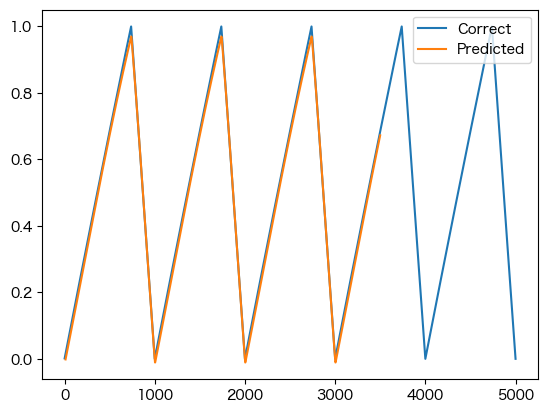

Epoch: 100, Loss_Train: 3.6041108643400553e-06


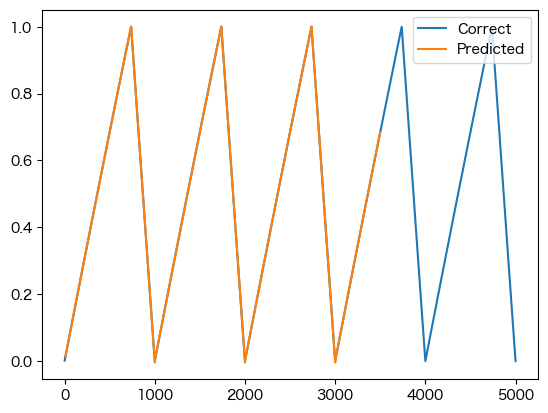

Epoch: 200, Loss_Train: 3.6101764648267296e-07


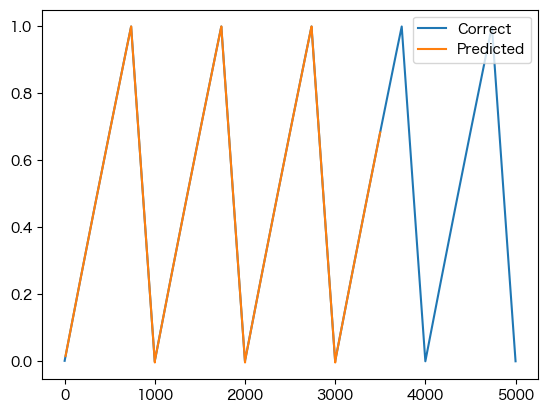

In [16]:
loss_fnc = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_record = []
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

net.to(device)

epochs = 200  # エポック数

for i in range(epochs + 1):
    net.train()  # 学習モード
    running_loss = 0.0  # 記録用loss初期化
    for _, (x, t) in enumerate(train_loader):  # データローダからバッチ毎に取り出す
        x = x.to(device)  # シーケンシャルデータをバッチサイズ分だけGPUへ
        optimizer.zero_grad()  # 勾配を初期化
        y = net(x)  # RNNで予測
        y = y.to("cpu")  # 予測結果をCPUに戻す
        loss = loss_fnc(y, t)  # MSEでloss計算
        loss.backward()  # 逆伝番
        optimizer.step()  # 勾配を更新
        running_loss += loss.item()  # バッチごとのlossを足していく
    running_loss /= len(train_loader)  # lossを平均化
    loss_record.append(running_loss)  # 記録用のlistにlossを加える

    """以下RNNの学習の経過を可視化するコード"""
    if i % 100 == 0:  # 今回は100エポック毎に学習がどう進んだか？を表示させる
        print(f"Epoch: {i}, Loss_Train: {running_loss}")
        input_train = list(input_data[0].reshape(-1))
        predicted_train_plot = []  # 学習結果plot用のlist
        net.eval()  # 予測モード
        for k in range(n_sample):  # 学習させる点の数だけループ
            x = torch.tensor(input_train[-time_stemp:])
            x = x.reshape(1, time_stemp, 1)  # 予測なので当然バッチサイズは1
            x = x.to(device).float()
            y = net(x)  # 予測
            y = y.to("cpu")  # 結果をCPUへ戻す

            if k <= n_sample - 2:
                input_train.append(input_data[k + 1][9].item())
            predicted_train_plot.append(y[0].item())

        plt.plot(range(len(df_scaled_y)), df_scaled_y, label="Correct")
        plt.plot(
            range(time_stemp, time_stemp + len(predicted_train_plot)),
            predicted_train_plot,
            label="Predicted",
        )
        plt.legend()
        plt.show()

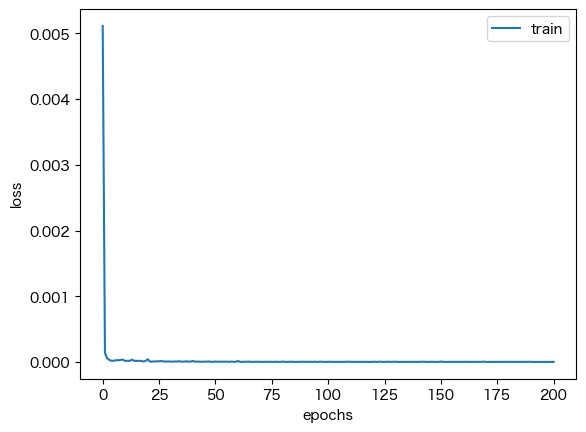

In [17]:
# 最後にlossの推移を確認
plt.plot(range(len(loss_record)), loss_record, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
